In [1]:
import pennylane as qml
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# --- 1. CONFIGURATION ---
# We keep the configuration consistent where possible
N_QUBITS = 4          # We will encode 16 pixels into 4 qubits (2^4 = 16)
N_LAYERS = 3          # Depth of the quantum variational layers
BATCH_SIZE = 10
EPOCHS = 6       
LR = 0.1             # Simple VQC often needs slightly higher LR than QCNN
TOTAL_WIRES = N_QUBITS

# Setup Device
dev = qml.device("default.qubit", wires=N_QUBITS)

# --- 2. QUANTUM CIRCUIT (VQC) ---
@qml.qnode(dev, interface="torch")
def vqc_circuit(inputs, weights):
    # 1. Embedding: 
    # We map 16 pixel values into the amplitudes of 4 qubits
    # normalize=True ensures the vector sums to 1 (quantum requirement)
    qml.AmplitudeEmbedding(inputs, wires=range(N_QUBITS), normalize=True)
    
    # 2. Variational Layers:
    # Tunable rotation and entanglement operations
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    
    # 3. Measure:
    # We measure the expectation value of all qubits to get features
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

In [3]:
class SimpleVQC(nn.Module):
    def __init__(self):
        super().__init__()
        weight_shapes = (N_LAYERS, N_QUBITS, 3)
        self.q_weights = nn.Parameter(torch.rand(weight_shapes))
        self.post_net = nn.Linear(N_QUBITS, 2)

    def forward(self, x):
        # *** CORRECTED LOGIC ***
        q_out_list = []
        for x_i in x:
            # 1. Execute QNode, get list of 4 scalar tensors
            out_i = vqc_circuit(x_i, self.q_weights)
            # 2. Stack these 4 scalar tensors into one [4] tensor
            q_out_list.append(torch.stack(out_i))
            
        # 3. Stack the batch: List of [4] tensors -> [Batch, 4] tensor
        q_out = torch.stack(q_out_list).float()
        
        # Classical post-processing
        logits = self.post_net(q_out)
        return logits

In [4]:
# --- 4. DATA LOADING HELPER ---
def load_and_resize_data(dataset_name, class_0, class_1, limit_train=150, limit_test=50):
    """
    Loads data and resizes 28x28 images to 4x4 vectors (length 16) 
    to fit into the Simple VQC.
    """
    # Resize to 4x4 (16 pixels) to fit on 4 qubits via Amplitude Encoding
    transform = transforms.Compose([
        transforms.Resize((4, 4)), 
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) # Normalize helps convergence
    ])
    
    # Select Dataset
    if dataset_name == "MNIST":
        train_ds = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        test_ds = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        train_ds = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
        test_ds = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
    else:
        raise ValueError("Unknown Dataset")

    # Filter for Binary Classification and Limit Size
    def filter_data(dataset, limit):
        # Pick only two specific classes
        idx = (dataset.targets == class_0) | (dataset.targets == class_1)
        
        # Get Data and flatten to 1D vector (16 features)
        data = dataset.data[idx][:limit].unsqueeze(1).float() / 255.0
        # Manual Resize if transform didn't apply to raw .data tensor
        data = torch.nn.functional.interpolate(data, size=(4,4)).view(limit, -1)
        
        # Ensure non-zero vectors for Amplitude Embedding
        data = data + 0.01 
        
        targets = dataset.targets[idx][:limit]
        
        # Remap targets to 0 and 1
        new_targets = torch.zeros_like(targets)
        new_targets[targets == class_1] = 1
        new_targets[targets == class_0] = 0
        return data, new_targets

    X_train, y_train = filter_data(train_ds, limit_train)
    X_test, y_test = filter_data(test_ds, limit_test)
    
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, test_loader

In [5]:
def run_training(dataset_name, class_0, class_1):
    print(f"\n--- Training Simple VQC on {dataset_name} ({class_0} vs {class_1}) ---")
    train_loader, test_loader = load_and_resize_data(dataset_name, class_0, class_1)
    
    model = SimpleVQC()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    
    history = []
    
    model.train()
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        history.append(avg_loss)
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return model, history, acc


--- Training Simple VQC on MNIST (3 vs 8) ---
Epoch 1/6 | Loss: 0.6993
Epoch 2/6 | Loss: 0.6114
Epoch 3/6 | Loss: 0.6203
Epoch 4/6 | Loss: 0.5809
Epoch 5/6 | Loss: 0.5618
Epoch 6/6 | Loss: 0.5932
Test Accuracy: 80.00%

--- Training Simple VQC on FashionMNIST (5 vs 7) ---
Epoch 1/6 | Loss: 0.6242
Epoch 2/6 | Loss: 0.4661
Epoch 3/6 | Loss: 0.3768
Epoch 4/6 | Loss: 0.3819
Epoch 5/6 | Loss: 0.3280
Epoch 6/6 | Loss: 0.3182
Test Accuracy: 84.00%


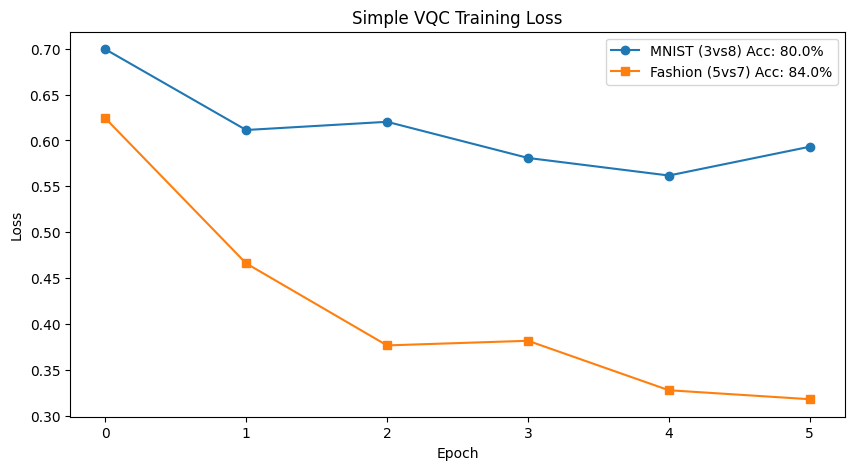

In [6]:
model_mnsit,mnist_hist, mnist_acc = run_training("MNIST", class_0=3, class_1=8)

# 2. Fashion MNIST (Sandals vs Sneakers)
model_fmnist,fmnist_hist, fmnist_acc = run_training("FashionMNIST", class_0=5, class_1=7)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(mnist_hist, label=f'MNIST (3vs8) Acc: {mnist_acc}%', marker='o')
plt.plot(fmnist_hist, label=f'Fashion (5vs7) Acc: {fmnist_acc}%', marker='s')
plt.title("Simple VQC Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()